# Data Visualization and Data Distributions
This notebook uses a jackknifed dataset to observe annual and seasonal differences in model parameters.

In [1]:
# Import relevant packages.
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read in the data... (previously jackknifed so that we have an approx equal number of sharks present vs
# sharks absent)
dat = pd.read_csv('D:/Documents/SpringBoard/capstone-1/datasets/final_files/combined/filled/jackknifed.csv', 
                  dtype={'Zone':'int64', 'Transmitter':'category', 
                         'animal_weight':'float64','animal_length_total':'float64', 
                         'gender':'category', 'location':'category', 'year':'category',
                         'Receiver_D':'float64', 'Lat':'float64', 'Lng':'float64', 
                         'DepthGradient':'float64', 'TempC':'float64', 'Sal':'float64',
                         'ChlA':'float64', 'MoonPhase':'category'}, 
                 parse_dates = ['Date'])

In [3]:
# Shmuel suggested we focus first on just the number of sharks detected in each zone
# each day. 

# So this takes a little bit of extra work
dat_sharks = dat[dat['Transmitter'] != 'NoSharks'] # keep only data where sharks are present
counts = dat_sharks[['Date','Zone','Transmitter']].groupby(['Zone','Date']).agg('count').reset_index()
    # and count the number of transmitters in each zone on each date
environ = dat_sharks[['Date', 'Zone', 'Receiver_D', 'Lat', 'Lng', 'DepthGradient', 'TempC', 
                      'Sal', 'ChlA', 'MoonPhase']]
    # grab the corresponding environmental data
environ = environ.drop_duplicates(subset=['Date','Zone']) # remove duplicates that were 
    # present because more than one shark was heard in a zone in a day
counts = counts.merge(environ) # now merge the environmental data back to the shark counts

# Now, take out the data with sharks from the main dataset, and replace it with the count data
dat = dat[dat['Transmitter'] == 'NoSharks'] # only keep data without sharks
dat = dat[['Zone', 'Date', 'Transmitter', 'Receiver_D', 'Lat', 'Lng', 'DepthGradient', 'TempC', 
           'Sal', 'ChlA', 'MoonPhase']]
    # only keep the relevant columns
dat = dat.append(counts) # and append the count data to this new dataframe

dat = dat.sort_values(['Date','Zone']) # finally, sort the data so that it's in sequential order

## We need to look at the overall distributions of all the parameters, in order to see if there are any outliers and to get an idea of what the data actually look like.

### Let's start with the number of sharks detected per zone per day.

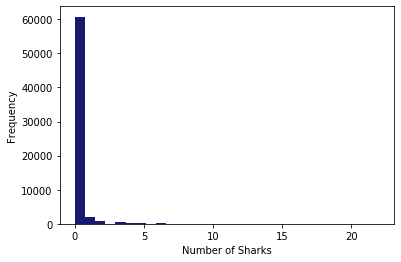

In [4]:
dat['Transmitter'] = pd.to_numeric(dat['Transmitter'], errors='coerce').fillna(0)
    # first, let's make sure that the transmitter column is a number, and 'NoSharks' == 0

# Plotting time.
dat['Transmitter'].plot(kind='hist', bins=30, color='midnightblue') # let's do a histogram
plt.xlabel('Number of Sharks') # with a nice x label
plt.show() # show plot

In [5]:
print('Mean Number of Sharks: ' + str(round(dat['Transmitter'].mean(), 4)))
print('Minimum Number of Sharks: ' + str(dat['Transmitter'].quantile(0)))
print('1st Quartile Value for Number of Sharks: ' + str(dat['Transmitter'].quantile(0.25)))
print('Median Number of Sharks: ' + str(dat['Transmitter'].quantile(0.5)))
print('3rd Quartile Value for Number of Sharks: ' + str(dat['Transmitter'].quantile(.75)))
print('Maximum Number of Sharks: ' + str(dat['Transmitter'].quantile(1)))

Mean Number of Sharks: 0.1552
Minimum Number of Sharks: 0.0
1st Quartile Value for Number of Sharks: 0.0
Median Number of Sharks: 0.0
3rd Quartile Value for Number of Sharks: 0.0
Maximum Number of Sharks: 22.0


It seems like most of the time 0 sharks are present. This is understandable, considering the amount of space and time that are covered by this dataset. However, on one day, 22 total sharks were present in a single zone -- that's a lot of sharks! I don't think that we should remove data where we get a large number of sharks, because maybe there is some environmental parameter that could explain this phenomenon.

Let's see how this changes over the course of the dataset. I have plotted a time series below.

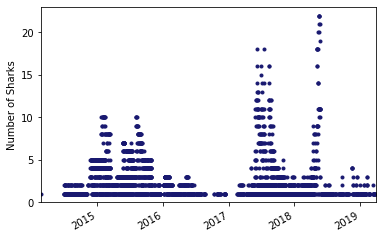

In [6]:
dat[dat['Transmitter'] > 0].plot(x='Date', y='Transmitter', style='.', color='midnightblue', legend=False)
    # let's plot date vs the number of sharks as little dots on the graph and let's just
    # ignore 0 values
plt.ylabel('Number of Sharks') # update the ylabel
plt.xlabel('') # update the xlabel
plt.show() # and show the plot

There seems to me some sort of seasonal/annual cycle here, where sharks are present at 'high' numbers for some part of the year, but are absent at others. This really started happening in about 2015 and had the highest peak during 2017 and 2018.

Perhaps this has something to do with environmental conditions, but it might also have to do with the number of receivers that are in the water listeing for tagged animals. Let's look into that next.

### Next up: The number of receivers deployed per zone per day.

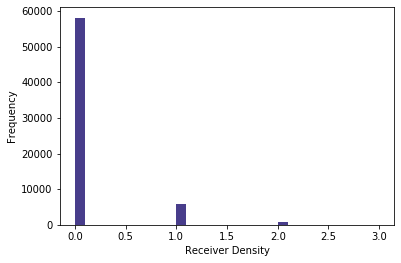

In [7]:
dat['Receiver_D'].plot(kind='hist', bins=30, color='darkslateblue') # let's do a histogram
plt.xlabel('Receiver Density') # with a nice x label
plt.show() # show plot

In [8]:
print('Mean Receiver Density: ' + str(round(dat['Receiver_D'].mean(), 4)))
print('Minimum Receiver Density: ' + str(dat['Receiver_D'].quantile(0)))
print('1st Quartile Value for Receiver Density: ' + str(dat['Receiver_D'].quantile(0.25)))
print('Median Receiver Density: ' + str(dat['Receiver_D'].quantile(0.5)))
print('3rd Quartile Value for Receiver Density: ' + str(dat['Receiver_D'].quantile(.75)))
print('Maximum Receiver Density: ' + str(dat['Receiver_D'].quantile(1)))

Mean Receiver Density: 0.116
Minimum Receiver Density: 0.0
1st Quartile Value for Receiver Density: 0.0
Median Receiver Density: 0.0
3rd Quartile Value for Receiver Density: 0.0
Maximum Receiver Density: 3.0


For most of the data, there are 0 receivers deployed in a zone in a day. This matches the histogram for the shark detection data; you can't detect sharks if the detection device isn't in the water! Let's see if the time series plot for receiver density matches the time series plot for the number of sharks detected. 

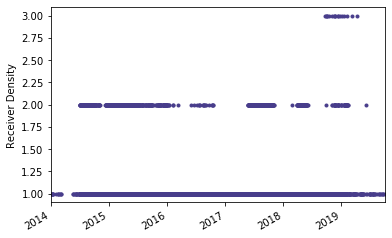

In [9]:
dat[dat['Receiver_D'] > 0].plot(x='Date', y='Receiver_D', style='.', color='darkslateblue', legend=False)
    # let's plot date vs the number of receivers as little dots on the graph and let's just
    # ignore 0 values
plt.ylabel('Receiver Density') # update the ylabel
plt.xlabel('') # update the xlabel
plt.show() # and show the plot

Looking at this, it seems like most of the time at least one receiver was in the water, so maybe shark presents isn't directly associated with receiver density, but other environmental conditions.

Let's re-draw this graph but looking at the total number of receivers deployed per day (adding up receivers in each zone).

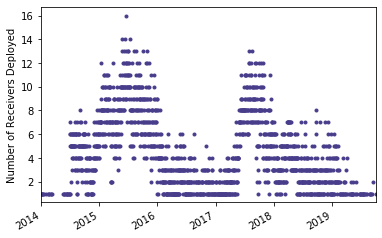

In [10]:
receivers = dat[['Date', 'Receiver_D']].groupby('Date').agg('sum')
receivers[receivers['Receiver_D'] > 0].plot(style='.', color='darkslateblue', legend=False)
    # let's plot date vs the number of receivers as little dots on the graph and let's just
    # ignore 0 values
plt.ylabel('Number of Receivers Deployed') # update the ylabel
plt.xlabel('') # update the xlabel
plt.show() # and show the plot

This is a lot more useful. It seems like there are peaks in the number of receivers deployed, and these peaks might match up with the number of sharks detected. However, it's not a perfect relationship, because the peaks aren't exactly the same. I think environmental conditions also play a role.

### Let's move on to seafloor depth gradient.

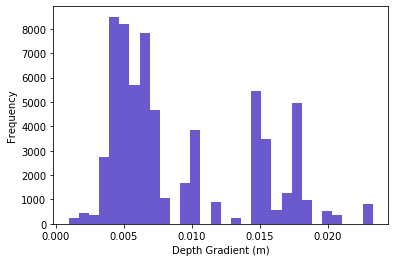

In [11]:
dat['DepthGradient'].plot(kind='hist', bins=30, color='slateblue')
    # let's plot this in 30 bins 
plt.xlabel('Depth Gradient (m)') # add the xlabel
plt.show() # and show the plot

In [12]:
print('Mean Depth Gradient: ' + str(round(dat['DepthGradient'].mean(), 4)))
print('Minimum Depth Gradient: ' + str(round(dat['DepthGradient'].quantile(0),4)))
print('1st Quartile Value for Depth Gradient: ' + str(round(dat['DepthGradient'].quantile(0.25), 4)))
print('Median Depth Gradient: ' + str(round(dat['DepthGradient'].quantile(0.5), 4)))
print('3rd Quartile Value for Depth Gradient: ' + str(round(dat['DepthGradient'].quantile(.75), 4)))
print('Maximum Depth Gradient: ' + str(round(dat['DepthGradient'].quantile(1), 4)))

Mean Depth Gradient: 0.0091
Minimum Depth Gradient: 0.0009
1st Quartile Value for Depth Gradient: 0.005
Median Depth Gradient: 0.0067
3rd Quartile Value for Depth Gradient: 0.0145
Maximum Depth Gradient: 0.0233


I don't really see a common distribution in these data. All changes in depth are small (less than 1 meter), so it might be too small of a difference to actually change the probability of shark presence. We'll see how the model responds to these data.

### Let's move on to temperature data. 

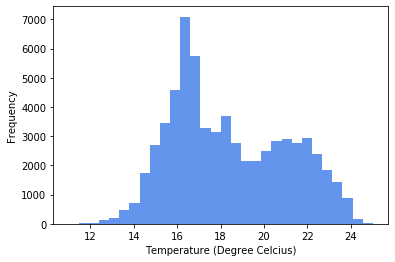

In [13]:
dat['TempC'].plot(kind='hist', bins=30, color='cornflowerblue') # let's do another
    # histogram for temperature
plt.xlabel('Temperature (Degree Celcius)') # fix the xlabel
plt.show() # and show the plot

In [14]:
print('Mean Temperature: ' + str(round(dat['TempC'].mean(), 4)))
print('Minimum Temperature: ' + str(round(dat['TempC'].quantile(0), 4)))
print('1st Quartile Value for Temperature: ' + str(round(dat['TempC'].quantile(0.25), 4)))
print('Median Temperature: ' + str(round(dat['TempC'].quantile(0.5), 4)))
print('3rd Quartile Value for Temperature: ' + str(round(dat['TempC'].quantile(.75), 4)))
print('Maximum Temperature: ' + str(round(dat['TempC'].quantile(1), 4)))

Mean Temperature: 18.3863
Minimum Temperature: 10.994
1st Quartile Value for Temperature: 16.294
Median Temperature: 17.876
3rd Quartile Value for Temperature: 20.701
Maximum Temperature: 25.021


This is a bimodal distribution, which is likely explained by different seasons having different water temperatures (warmer in summer and cooler in winter). Overall, temperatures are about 17-18 degrees Celcius between 2014 and 2019. 

Let's look at the time series data in the next plot.

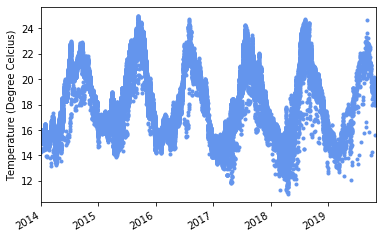

In [15]:
dat.plot(x='Date',y='TempC', style='.', color='cornflowerblue', legend=False)
    # plot the time series data
plt.ylabel('Temperature (Degree Celcius)') # fix the ylabel
plt.xlabel('') # fix the xlabel
plt.show() # show the plot

This graph definitely explains the bimodal distribution we saw above. During the winter (the beginnig of the year), temperatures drop. It does seem like temperatures are hitting lower temperatures in more recent years (2017-2019) compared to before 2017. This might explain why the peaks in the previous graph were not the same height. Maybe this larger temperature gradient could explain the higher number of observed sharks in 2017 and 2018. 

### The next thing we should check out is the salinity values.

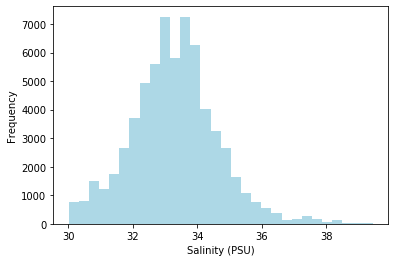

In [16]:
dat['Sal'].plot(kind='hist', bins=30, color='lightblue') # plot a histogram of salinity values
plt.xlabel('Salinity (PSU)') # add xlabel
plt.show() # show the plot

In [17]:
print('Mean Salinity: ' + str(round(dat['Sal'].mean(), 4)))
print('Minimum Salinity: ' + str(round(dat['Sal'].quantile(0), 4)))
print('1st Quartile Value for Salinity: ' + str(round(dat['Sal'].quantile(0.25), 4)))
print('Median Salinity: ' + str(round(dat['Sal'].quantile(0.5), 4)))
print('3rd Quartile Value for Salinity: ' + str(round(dat['Sal'].quantile(.75), 4)))
print('Maximum Salinity: ' + str(round(dat['Sal'].quantile(1), 4)))

Mean Salinity: 33.2881
Minimum Salinity: 30.0025
1st Quartile Value for Salinity: 32.4435
Median Salinity: 33.2741
3rd Quartile Value for Salinity: 34.0522
Maximum Salinity: 39.4414


Salinity appears to be a slightly skewed normal distribution with most data around 33 PSU. We may want to consider removing super salty (> 34 PSU, greater than the third quartile of data) conditions from the dataset, since it might have to do with environmental anomalies. However, I think we should first look and see how the model reacts to the high salinity values. Perhaps this occurs at times where sharks are definitely <i>not</i> around? It might be a strong driving force for these animals.

Let's see if there's an obvious annual/seasonal relationship for salinity.

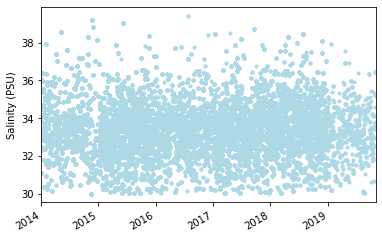

In [18]:
dat.plot(x='Date',y='Sal', style='.', color='lightblue', legend=False)
    # a nice little dot graph for the salinity data
plt.ylabel('Salinity (PSU)') # label the y axis
plt.xlabel('') # label the x axis
plt.show() # show the plot

There doesn't seem to be an obvious cycle for when Salinity values are super high, so it might just be part of a normal change that affects nearshore waters from time to time.

### Let's move on to Chlorophyll-A.

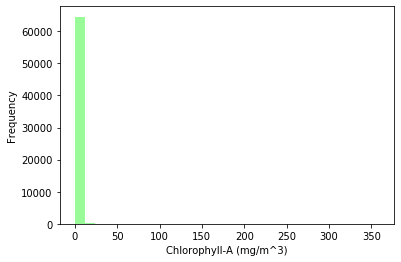

In [19]:
dat['ChlA'].plot(kind='hist', bins=30, color='palegreen') # let's plot a histogram for these data
plt.xlabel('Chlorophyll-A (mg/m^3)') # update the xlabel
plt.show() # and show the plot.

In [20]:
print('Mean Chlorophyll-A: ' + str(round(dat['ChlA'].mean(), 4)))
print('Minimum Chlorophyll-A: ' + str(round(dat['ChlA'].quantile(0), 4)))
print('1st Quartile Value for Chlorophyll-A: ' + str(round(dat['ChlA'].quantile(0.25), 4)))
print('Median Chlorophyll-A: ' + str(round(dat['ChlA'].quantile(0.5), 4)))
print('3rd Quartile Value for Chlorophyll-A: ' + str(round(dat['ChlA'].quantile(.75), 4)))
print('Maximum Chlorophyll-A: ' + str(round(dat['ChlA'].quantile(1), 4)))

Mean Chlorophyll-A: 0.8508
Minimum Chlorophyll-A: 0.0
1st Quartile Value for Chlorophyll-A: 0.1769
Median Chlorophyll-A: 0.3171
3rd Quartile Value for Chlorophyll-A: 0.5774
Maximum Chlorophyll-A: 359.2543


Most chlorophyll levels are small (< 1), but there's one really high value of 360. I think this might be a bad value, so we definitely should take it out of the dataset prior to running our models.

Let's see if we can pinpoint dates when these values are high.

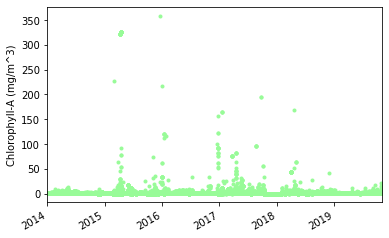

In [21]:
dat.plot(x='Date',y='ChlA', style='.', color='palegreen', legend=False)
    # build a time series plot
plt.ylabel('Chlorophyll-A (mg/m^3)') # add ylabel
plt.xlabel('') # add xlabel
plt.show() # show the plot

It seems like there's an annual peak in Chlorophyll-A from 2015-2019. It might indicate a harmful algal bloom, or it might indicate an instrument error in the measurement itself. We also see that there are actually quite a few points over 50 mg/m^3... We should look into historical accounts of harmful algal blooms and keep data that correspond to those time periods, but remove data that show high Chlorophyll levels and are not backed up by historical reports. 

### Finally, moon phase. 
Most categorical data in my original dataset corresponded to individual sharks (things like sex, tagging location, tagging cohort). Most of those data were lost when I took overall counts of sharks in each zone. However, I can add this back in later if I want to make my model answer more specific questions.

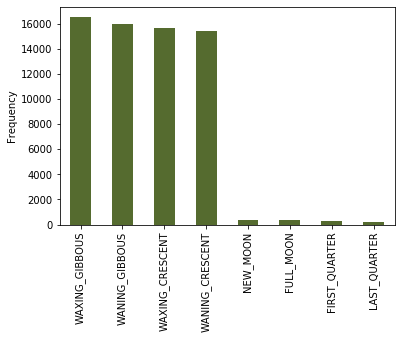

In [22]:
dat['MoonPhase'].value_counts().plot(kind='bar', color='darkolivegreen')
    # let's get the number of values in each moon phase category and plot them
plt.ylabel('Frequency') # add the ylabel
plt.show() # and show the plot

In [23]:
print(dat['MoonPhase'].value_counts()) # let's print out the value data

WAXING_GIBBOUS     16525
WANING_GIBBOUS     15974
WAXING_CRESCENT    15670
WANING_CRESCENT    15445
NEW_MOON             390
FULL_MOON            369
FIRST_QUARTER        259
LAST_QUARTER         183
Name: MoonPhase, dtype: int64


First quarter, last quarter, new moon, and full moon occur on much fewer days than the waxing and waning moon phases. I think we might want to consider only using data with waxing/waning lunar phases so that the sample sizes are approximately the same.